In [2]:
import pandas as pd
import folium
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
import numpy as np

# Load the filtered dataset
file_path ='Filtered_US_Accidents_CA.csv'
df = pd.read_csv(file_path)

# Convert Start_Time to datetime with error handling
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Drop rows where Start_Time could not be parsed
df = df.dropna(subset=['Start_Time'])

eps_meters_change = 1000
# Function to apply DBSCAN clustering
def apply_dbscan(df, eps_meters=300, min_samples=1500):
    # Convert meters to radians
    eps = eps_meters / 6371000.0  # Earth's radius in meters
    coords = df[['Start_Lat', 'Start_Lng']].to_numpy()
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    df['Cluster'] = cluster_labels
    return df, len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Apply clustering to the entire dataset
df_clustered, num_clusters = apply_dbscan(df, eps_meters_change)

# List of hospitals
hospitals = [
    {"name": "Cedars-Sinai Medical Center", "lat": 34.0754, "lng": -118.3804},
    {"name": "UCLA Medical Center", "lat": 34.0650, "lng": -118.4442},
    {"name": "Keck Hospital of USC", "lat": 34.0616, "lng": -118.2050},
    {"name": "LAC+USC Medical Center", "lat": 34.0582, "lng": -118.2100},
    {"name": "California Hospital Medical Center", "lat": 34.0391, "lng": -118.2674},
    {"name": "Good Samaritan Hospital", "lat": 34.0562, "lng": -118.2650},
    {"name": "Kaiser Permanente Los Angeles Medical Center", "lat": 34.0974, "lng": -118.2915},
    {"name": "Hollywood Presbyterian Medical Center", "lat": 34.0968, "lng": -118.2911},
    {"name": "Martin Luther King Jr. Community Hospital", "lat": 33.9223, "lng": -118.2630},
    {"name": "Adventist Health White Memorial", "lat": 34.0441, "lng": -118.2088},
    {"name": "Dignity Health - California Hospital Medical Center", "lat": 34.0328, "lng": -118.2673},
    {"name": "Adventist Health Glendale", "lat": 34.1416, "lng": -118.2538},
    {"name": "Providence Saint John's Health Center", "lat": 34.0277, "lng": -118.4845},
    {"name": "Ronald Reagan UCLA Medical Center", "lat": 34.0689, "lng": -118.4441},
    {"name": "Children's Hospital Los Angeles", "lat": 34.0986, "lng": -118.2927},
    {"name": "Kaiser Permanente South Bay Medical Center", "lat": 33.8896, "lng": -118.3034},
    {"name": "Providence Little Company of Mary Medical Center - Torrance", "lat": 33.8322, "lng": -118.3284},
    {"name": "Gateways Hospital and Mental Health Center", "lat": 34.0918, "lng": -118.2495},
    {"name": "Keck Medicine of USC - USC Treatment Center (HC3)", "lat": 34.0623, "lng": -118.2043},
    {"name": "Helipad Hospital", "lat": 34.0761, "lng": -118.3673},
    {"name": "Ocean View Adult Psychiatric Hospital", "lat": 33.7890, "lng": -118.1408},
    {"name": "5525 W Slauson Ave, Los Angeles, CA 90056, United States", "lat": 33.9875, "lng": -118.3686},
    {"name": "555 E Hardy St, Inglewood, CA 90301, United States", "lat": 33.9660, "lng": -118.3437},
    {"name": "2623 Slauson Ave, Huntington Park, CA 90255, United States", "lat": 33.9795, "lng": -118.2276},
    {"name": "3330 Lomita Blvd, Torrance, CA 90505, United States", "lat": 33.8185, "lng": -118.3485},
    {"name": "1000 W Carson St, Torrance, CA 90502, United States", "lat": 33.8304, "lng": -118.3091}
]



def update_map(selected_date):
    df_filtered_day = df[df['Start_Time'].dt.strftime('%Y-%m-%d') == selected_date]

    # Calculate total number of incidents
    total_incidents = len(df_filtered_day)
    
    # Print number of incidents for the selected date
    print(f"Number of incidents on {selected_date}: {total_incidents}")
    # Calculate weather conditions and their percentages
    total_incidents = len(df_filtered_day)
    weather_counts = df_filtered_day['Weather_Condition'].value_counts()
    weather_percentages = (weather_counts / total_incidents) * 100

    # Print weather conditions and percentages
    print(f"Weather conditions on {selected_date}:")
    for weather_condition, percentage in weather_percentages.items():
        print(f"{weather_condition}: {percentage:.2f}%")

    # Create a base map
    m = folium.Map(location=[34.0522, -118.2437], zoom_start=11)  # Centered around Los Angeles

    # Add clusters to the map
    for cluster_id in range(num_clusters):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
        if not cluster_data.empty:
            center_lat = cluster_data['Start_Lat'].mean()
            center_lng = cluster_data['Start_Lng'].mean()
            folium.Marker(
                location=[center_lat, center_lng],
                icon=folium.Icon(color='green', icon='info-sign'),
                popup=f"Cluster {cluster_id}<br>Incidents: {len(cluster_data)}"
            ).add_to(m)
            
            # Draw circle for the cluster
            folium.Circle(
                location=[center_lat, center_lng],
                radius=eps_meters_change,  # Radius in meters
                color='blue',
                fill=True,
                fill_opacity=0.2,
                popup=f"Cluster {cluster_id}<br>Incidents: {len(cluster_data)}"
            ).add_to(m)

    # Add points for the selected day to the map
    for index, row in df_filtered_day.iterrows():
        folium.CircleMarker(
            location=[row['Start_Lat'], row['Start_Lng']], 
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"Time: {row['Start_Time']}<br>Weather: {row['Weather_Condition']}<br>Cluster: {row['Cluster']}"
        ).add_to(m)

    # Add hospital locations to the map
    for hospital in hospitals:
        # Default hospital icon
        folium.Marker(
            location=[hospital["lat"], hospital["lng"]],
            icon=folium.Icon(color='darkpurple', icon='hospital-o'),
            popup=hospital["name"]
        ).add_to(m)
        
        # Add 'H' letter on top
        folium.Marker(
            location=[hospital["lat"], hospital["lng"]],
            icon=folium.DivIcon(
                icon_size=(150, 36),
                icon_anchor=(7, 20),
                html='<div style="font-size: 12pt; color: Blue;">Hospital</div>'
            ),
        ).add_to(m)

    # Display the map
    display(m)


def on_date_change(change):
    clear_output(wait=True)
    display(date_picker)
    update_map(change['new'].strftime('%Y-%m-%d'))

# Create a date picker widget
date_picker = widgets.DatePicker(
    description='Pick a Date',
    value=pd.to_datetime('2023-01-01')
)

print(num_clusters)

date_picker.observe(on_date_change, names='value')

display(date_picker)
update_map(date_picker.value.strftime('%Y-%m-%d'))


8


DatePicker(value=Timestamp('2023-01-01 00:00:00'), description='Pick a Date', step=1)

Number of incidents on 2023-01-01: 55
Weather conditions on 2023-01-01:
Fair: 56.36%
Partly Cloudy: 20.00%
Light Rain: 9.09%
Cloudy: 9.09%
Mostly Cloudy: 3.64%
Cloudy / Windy: 1.82%


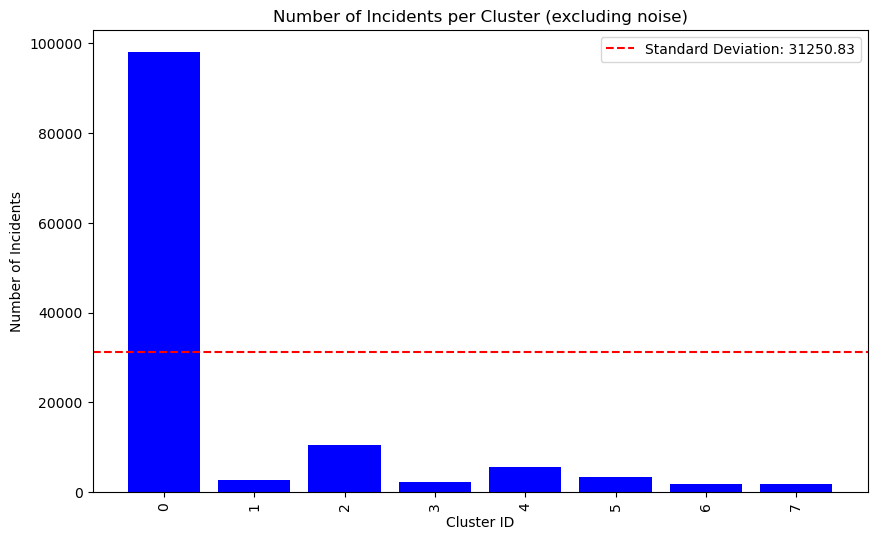

Standard Deviation of number of incidents per cluster (excluding noise): 31250.83350088442


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of incidents in each cluster, excluding cluster -1
cluster_counts = df_clustered[df_clustered['Cluster'] != -1]['Cluster'].value_counts().sort_index()

# Calculate the standard deviation
std_dev = np.std(cluster_counts)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color='blue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents per Cluster (excluding noise)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add a line for the standard deviation
plt.axhline(y=std_dev, color='r', linestyle='--', label=f'Standard Deviation: {std_dev:.2f}')
plt.legend()

plt.show()

print(f"Standard Deviation of number of incidents per cluster (excluding noise): {std_dev}")
